In [1]:
import os

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as transforms
from easydict import EasyDict as edict
from imutils.paths import list_images
from matplotlib import pyplot as plt
import torch.optim as optim
import albumentations as A
import torch.nn as nn
import seaborn as sns 
import numpy as np
import torch
import cv2

from utils.dataset_util import *

/opt/conda/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/ml/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
SEP       = os.path.sep
ROOT_PATH = SEP.join(os.getcwd().split(SEP)[:-3])
DATA_PATH = f'{ROOT_PATH}/Dataset/brain_tumor'

In [3]:
get_labels = lambda image_paths: [image_path.split(SEP)[-2] for image_path in image_paths]

train_paths  = sorted(list_images(f'{DATA_PATH}/Training'))
test_paths   = sorted(list_images(f'{DATA_PATH}/Testing'))

train_labels = get_labels(train_paths)
test_labels  = get_labels(test_paths)

lb2idx       = {lb  : idx for idx,  lb in enumerate(set(train_labels))}
idx2lb       = {idx :  lb for lb , idx in lb2idx.items()}

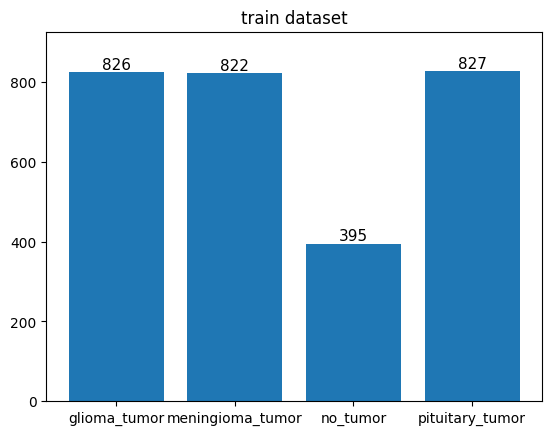

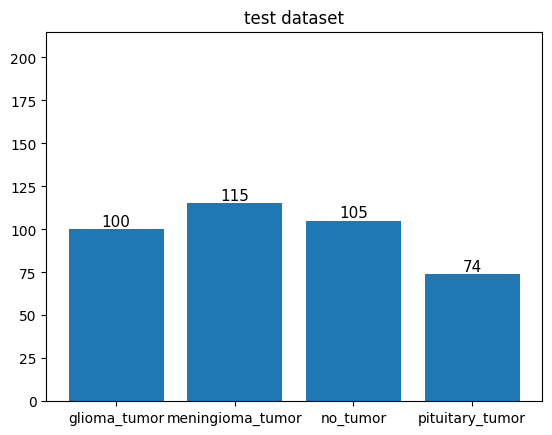

In [4]:
display_distribution(train_labels)
display_distribution(test_labels, dtype = 'test')

(-0.5, 511.5, 511.5, -0.5)

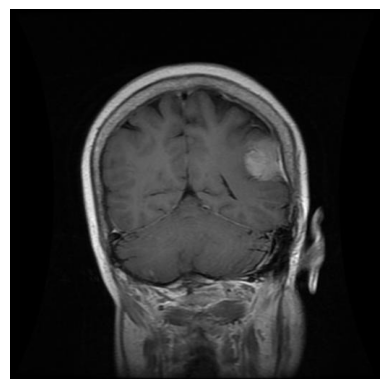

In [5]:
sample = cv2.imread(train_paths[999])
plt.imshow(sample)
plt.axis(False)

(-0.5, 298.5, 298.5, -0.5)

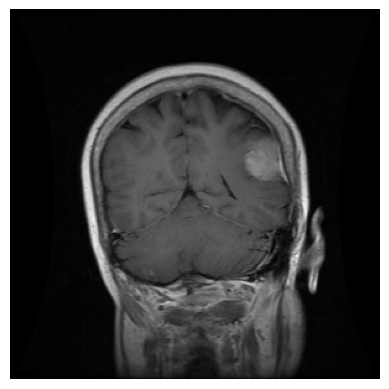

In [6]:
transform = A.Compose([
                        A.Resize(width = 299, height = 299),
                        A.HorizontalFlip(p = 0.5),
                      ])
sample_transformed = transform(image = sample)['image']
plt.imshow(sample_transformed)
plt.axis(False)

In [7]:
def build_dataset(image_paths):
    
    images, labels = [], []
    for image_path in image_paths:
        
        image = cv2.imread(image_path)
        image = cv2.resize(image, (312, 312))
        
        label = image_path.split(SEP)[-2]
        images.append(image)
        labels.append(label)
    
    labels = [lb2idx[lb] for lb in labels]
    images, labels = np.array(images), np.array(labels)
    
    return images, labels


train_images, train_labels = build_dataset(train_paths)
test_images ,  test_labels = build_dataset(test_paths)

In [8]:
class TumorDataset(Dataset):
    
    def __init__(self, images, labels, dtype = 'train'):
        
        self.images = images
        self.labels = labels
        self.dtype  = dtype
        
        self.transform          = {}
        self.transform['train'] = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.CenterCrop(299),
                                    transforms.RandomHorizontalFlip(p = 0.5),
                                    transforms.ToTensor()
                                  ])
        self.transform['test']  = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize(299),
                                    transforms.ToTensor()
                                ])
        
    def __len__(self):
        return len(self.labels)
    
    
    def __getitems__(self, idx):
        
        image = self.images[idx]
        print(image.shape)
        
        image = self.transform[self.dtype](image)
        print(image.shape)
        
        return image, self.labels[idx]

In [9]:
train_dataset = TumorDataset(train_images, train_labels)
test_dataset  = TumorDataset(test_images ,  test_labels, dtype = 'test')

train_loader  = DataLoader(train_dataset, batch_size = 64, shuffle =  True)
test_loader   = DataLoader(test_dataset , batch_size =  1, shuffle = False)